In [ ]:
import json
from functools import partial
from typing import List, Iterable
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

### Load data

In [13]:
dataset = pd.read_parquet("/kaggle/input/hackathon-files-for-participants-ozon/train_pairs.parquet")
etl = pd.read_parquet("/kaggle/input/hackathon-files-for-participants-ozon/train_data.parquet")

In [14]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [15]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [16]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


In [17]:
etl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457063 entries, 0 to 457062
Data columns (total 8 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   variantid                          457063 non-null  int64 
 1   name                               457063 non-null  object
 2   categories                         457063 non-null  object
 3   color_parsed                       378652 non-null  object
 4   pic_embeddings_resnet_v1           303467 non-null  object
 5   main_pic_embeddings_resnet_v1      457063 non-null  object
 6   name_bert_64                       457063 non-null  object
 7   characteristic_attributes_mapping  457036 non-null  object
dtypes: int64(1), object(7)
memory usage: 27.9+ MB


In [18]:
import re
from copy import copy
from transformers import BertTokenizer, BertModel


# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertModel.from_pretrained("bert-base-multilingual-cased")

def percent_of_intersection(lst1, lst2):
    min_len = min(len(lst1), len(lst2))
    
    return len(list(set(lst1) & set(lst2))) / min_len if min_len > 0 else 0

def get_words_and_num_values(tokens):
    words = []
    numerical_values = []
    for token in tokens:
        if bool(re.search('[0-9]', token)):
            if bool(re.search('[а-яА-ЯёЁa-zA-Z]', token)):
                numerical_values.append(copy(token))
            else:
                numerical_values.append(copy(token))
        else:
            if bool(re.search('[a-zA-Z]', token)):
                if len(token) > 4:
                    words.append(copy(token))
                else:
                    numerical_values.append(copy(token))
            else:
                words.append(copy(token))

    return words, numerical_values


def tokenize_text(text):
    delimiters = '-', '. ', ' ', ':', '/', ', ', '\'', '\"'
    text += ' '
    regex_pattern = '|'.join(map(re.escape, delimiters))
    tokens = re.split(regex_pattern, text)
    return tokens


def texts_to_intersection_percent(t1, t2):
    _, nums1 = get_words_and_num_values(tokenize_text(t1))
    _, nums2 = get_words_and_num_values(tokenize_text(t2))
    return percent_of_intersection(nums1, nums2)
    


def text_to_emb(text, model, tokenizer):
    tokens = tokenize_text(text)
    words, _ = get_words_and_num_values(tokens)
    limit = 512  # есть названия больше, из берт не принимает :(
    new_text = ' '.join(words)[:512]
    encoded_input = tokenizer(new_text, return_tensors='pt')
    emb = model(**encoded_input)
    
    return emb


# def text_to_emb_and_num_vals_and_insterction_percent(text, model, tokenizer):
#     tokens = tokenize_text(text)
#     words, numerical_values = get_words_and_num_values(tokens)
#     new_text = ' '.join(words)
#     encoded_input = tokenizer(new_text, return_tensors='pt')
#     emb = model(**encoded_input)
    
#     return emb, numerical_values, insterction_percent

In [19]:
# text1 = 'Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,30 метров,IP 44'

# text_to_emb(text1, model, tokenizer)[1].detach().numpy()[0].shape

In [20]:
# etl[["eugene_bert_embedding"]] = (
#     etl["name"].apply(
#         lambda x: pd.Series(text_to_emb(x, model, tokenizer)[1].detach().numpy()[0])
#     )
# )

In [21]:
# etl['eugene_bert_embedding'] = np.nan

# for ind in tqdm(etl.index):
#     text_to_emb(etl.at[ind, 'name'], model, tokenizer)[1].detach().numpy()[0]

In [22]:
# for product in tqdm(etl.itertuples(), total = len(etl)):
#     text_to_emb(product.name, model, tokenizer)[1].detach().numpy()[0]

In [23]:
# etl['eugene_bert_embedding'] = np.nan

# total = 0
# for website in websites.itertuples():
#     total += website.total_views
# return total

In [24]:
# решил для каждого типа фичей посмотреть на несколько примеров
from collections import defaultdict 

d = defaultdict(list)

example_ids = [0, 100, 1000, 10000]

for i in example_ids:
    for key in etl:
        d[key].append(etl[key][i])

In [25]:
d["categories"][0]

'{"1": "EPG", "2": "Электроника", "3": "Сетевые фильтры, разветвители и удлинители", "4": "Сетевой фильтр, удлинитель, разветвитель"}'

Get raw data for each variantid.

In [26]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [27]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


Features functions.

In [28]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features


In [29]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [30]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

# btw try to add distances between main pic embs

In [31]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

In [32]:
# # Добавим расстояния для фичей от Жени

# features[["euclidean_eugene_name_bert_dist", "cosine_eugene_name_bert_dist"]] = (
#     features[["eugene_bert_embedding1", "eugene_bert_embedding2"]].apply(
#         lambda x: pd.Series(text_dense_distances(*x)), axis=1
#     )
# )

# # try to use your favorite NLP model

In [33]:
# добавим долю совпадающих численных значений

features[["numerical_intersection_percent"]] = (
    features[["name1", "name2"]].apply(
        lambda x: pd.Series(texts_to_intersection_percent(*x)), axis=1
    )
)

In [34]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

Let's find good cat size threshold

In [35]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

10k for "rest" cats probably is good

In [36]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [37]:
import torch.nn as nn

In [38]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
def dist(input_1, input_2):
    return 1 - cos(input_1, input_2)
    #return nn.functional.pairwise_distance(input_1, input_2)

In [39]:
#nn.functional.pairwise_distance(s, s1)

In [40]:
#! Переписать бы как это уже было сделано выше

features['main_cos_dist'] = np.nan
features['main_evc_dist'] = np.nan
#from scipy.spatial.distance import cdist
from scipy import spatial
for ind in tqdm(features.index):
    #print(ind)
    cosine_val = cosine(features['main_pic_embeddings_resnet_v11'][ind][0], features['main_pic_embeddings_resnet_v12'][ind][0])
    evlid_val = euclidean(features['main_pic_embeddings_resnet_v11'][ind][0], features['main_pic_embeddings_resnet_v12'][ind][0])
    features.at[ind, 'main_cos_dist'] = cosine_val
    features.at[ind, 'main_evc_dist'] = evlid_val

100%|██████████| 306540/306540 [01:11<00:00, 4276.56it/s]


Choose features

In [41]:
feats = [
    "pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
    'euclidean_name_bert_dist', 'cosine_name_bert_dist',
#     'numerical_intersection_percent', 'eugene_bert_embedding1', "eugene_bert_embedding2",
    'numerical_intersection_percent',
    'main_cos_dist', 'main_evc_dist']

Split dataset

In [42]:
siamese_feats = ['main_pic_embeddings_resnet_v12', 'main_pic_embeddings_resnet_v11']

In [44]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"] + siamese_feats] ,
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"] + siamese_feats], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]
y_val_full = X_val[["target", "variantid1", "variantid2"]]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

Train model

In [45]:
models_path = "models"
if not os.path.exists(models_path):
   os.makedirs(models_path)

In [46]:
model = CatBoostClassifier()

model.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)
model.save_model(f"./models/baseline.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123728
0:	learn: 0.6593535	test: 0.6591851	best: 0.6591851 (0)	total: 113ms	remaining: 1m 52s


100:	learn: 0.5117145	test: 0.5096240	best: 0.5096240 (100)	total: 5.21s	remaining: 46.4s
200:	learn: 0.4991001	test: 0.4988637	best: 0.4988637 (200)	total: 11.2s	remaining: 44.6s
300:	learn: 0.4918438	test: 0.4941857	best: 0.4941857 (300)	total: 16.5s	remaining: 38.2s
400:	learn: 0.4863824	test: 0.4912924	best: 0.4912924 (400)	total: 21.6s	remaining: 32.3s
500:	learn: 0.4818511	test: 0.4895245	best: 0.4895245 (500)	total: 26.8s	remaining: 26.7s
600:	learn: 0.4779338	test: 0.4882246	best: 0.4882246 (600)	total: 31.9s	remaining: 21.2s
700:	learn: 0.4743256	test: 0.4872197	best: 0.4871879 (699)	total: 37.1s	remaining: 15.8s
800:	learn: 0.4711851	test: 0.4863294	best: 0.4863294 (800)	total: 44.2s	remaining: 11s
900:	learn: 0.4682064	test: 0.4858485	best: 0.4858206 (888)	total: 49.4s	remaining: 5.43s
999:	learn: 0.4653841	test: 0.4853224	best: 0.4853224 (999)	total: 54.4s	remaining: 0us

bestTest = 0.4853223726
bestIteration = 999



In [101]:
model2 = CatBoostClassifier()

model2.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)
model2.save_model(f"./models/baseline2.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123728
0:	learn: 0.6593535	test: 0.6591851	best: 0.6591851 (0)	total: 55.7ms	remaining: 55.7s


100:	learn: 0.5117145	test: 0.5096240	best: 0.5096240 (100)	total: 5.22s	remaining: 46.4s
200:	learn: 0.4991001	test: 0.4988637	best: 0.4988637 (200)	total: 10.3s	remaining: 40.9s
300:	learn: 0.4918438	test: 0.4941857	best: 0.4941857 (300)	total: 15.6s	remaining: 36.2s
400:	learn: 0.4863824	test: 0.4912924	best: 0.4912924 (400)	total: 21.7s	remaining: 32.4s
500:	learn: 0.4818511	test: 0.4895245	best: 0.4895245 (500)	total: 26.8s	remaining: 26.7s
600:	learn: 0.4779338	test: 0.4882246	best: 0.4882246 (600)	total: 31.9s	remaining: 21.2s
700:	learn: 0.4743256	test: 0.4872197	best: 0.4871879 (699)	total: 37s	remaining: 15.8s
800:	learn: 0.4711851	test: 0.4863294	best: 0.4863294 (800)	total: 42s	remaining: 10.4s
900:	learn: 0.4682064	test: 0.4858485	best: 0.4858206 (888)	total: 47.1s	remaining: 5.18s
999:	learn: 0.4653841	test: 0.4853224	best: 0.4853224 (999)	total: 53.1s	remaining: 0us

bestTest = 0.4853223726
bestIteration = 999



In [47]:
class DistDataset(Dataset):
    def __init__(self, feats_df: pd.DataFrame, target_df: pd.DataFrame, target_name: str = "target"):
        """
        Args:
            dist_df: dataframe that contains only columns representing
            distances between properties of a product pair and 'target' column
            that equals 1 if the pair is same product, otherwise 0
        """
        features_as_cols = [feats_df[key] for key in feats_df]
        self.features = list(zip(*features_as_cols))
        self.labels = list(target_df)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        inp = torch.tensor(self.features[idx])
        label = self.labels[idx]
        return inp, label

In [48]:
# DistDataset with numpy backend

# class DistDatasetNp(Dataset):
#     def __init__(self, dist_df: pd.DataFrame, target_name: str = "target"):
#         """
#         Args:
#             dist_df: dataframe that contains only columns representing
#             distances between properties of a product pair and 'target' column
#             that equals 1 if the pair is same product, otherwise 0
#         """
#         self.features = dist_df.drop('target', axis = 1).to_numpy().T
#         self.labels = dist_df['target'].to_numpy()
#     def __len__(self):
#         return len(self.features.T)
#     def __getitem__(self, idx):
#         inp = torch.tensor(self.features[idx])
#         label = self.labels[idx]
#         return inp, label

In [49]:
# class DistDataset(DistDatasetZip):
#     pass

In [50]:
dist_feats = [
    "pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
    'euclidean_name_bert_dist', 'cosine_name_bert_dist',
#     'numerical_intersection_percent', 'eugene_bert_embedding1', "eugene_bert_embedding2",
    'main_cos_dist', 'main_evc_dist']

In [51]:
train_dataset = DistDataset(X_train[dist_feats], y_train)
val_dataset = DistDataset(X_val[dist_feats], y_val)
test_dataset = DistDataset(X_test[dist_feats], y_test['target'])
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False, drop_last=False)
dataloaders = {'train':train_dataloader, 'val':val_dataloader}

In [52]:
X_train[dist_feats]

,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_bert_dist,cosine_name_bert_dist,main_cos_dist,main_evc_dist
68341,-1.000000,-1.000000,-1.000000,0.412746,0.004632,0.039550,1.868696
187573,0.000000,3.834663,5.543013,0.377481,0.003956,0.000000,0.000000
157454,-1.000000,-1.000000,-1.000000,0.591899,0.010588,0.029861,1.794320
16957,-1.000000,-1.000000,-1.000000,0.408357,0.004789,0.034551,1.712504
270799,-1.000000,-1.000000,-1.000000,0.479424,0.006767,0.000000,0.000000
...,...,...,...,...,...,...,...
171008,1.210842,3.224904,5.484363,0.000000,0.000000,0.080943,2.080464
113352,0.000000,0.000000,3.391108,0.437821,0.005302,0.000000,0.000000
238878,3.909940,5.001962,5.394721,0.344957,0.003759,0.236717,3.875215
186693,0.000000,4.009521,5.659083,0.238374,0.001682,0.000000,0.000000


In [53]:
# from sklearn import preprocessing
# x = dist_df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# norm_dist_df = pd.DataFrame(x_scaled)
# norm_dist_df

In [54]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix
# model = LogisticRegression(solver='liblinear', random_state=0)
# model = model.fit(X_train[dist_feats], y_train)

In [55]:
# y_pred = model.predict(X_val[dist_feats])
# print(classification_report(y_pred, y_val))

In [56]:
# from sklearn import preprocessing
# x = X_train[dist_feats].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# norm_dist_X_train = pd.DataFrame(x_scaled)

# x = X_val[dist_feats].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# norm_dist_X_test = pd.DataFrame(x_scaled)

In [57]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix
# model = LogisticRegression(solver='liblinear', random_state=0)
# model = model.fit(norm_dist_X_train, y_train)
# y_pred = model.predict(norm_dist_X_test)
# print(classification_report(y_pred, y_val))

In [58]:
class Mega_model(nn.Module):
    def __init__(self, in_feats):
        super(Mega_model, self).__init__()
        self.fc1 = nn.Linear(in_features=in_feats, out_features=in_feats)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=in_feats, out_features=in_feats)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=in_feats, out_features=2)
        self.Softmax = nn.Softmax(dim=1)
    def forward(self, input_feat):
        x = self.fc1(input_feat)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        out = self.Softmax(x)
        return out

In [65]:
from sklearn.metrics import f1_score, accuracy_score
epox_num = 20
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net_model = Mega_model(len(dist_feats)).to(device)

epox_list = [i for i in range(epox_num)]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_model.parameters(), lr=3e-3)

In [66]:
def train_model(model, criterion, optimizer, num_epochs, dataset):
    loss_list = {phase : [] for phase in dataset.keys()}
    acc_list = {phase : [] for phase in dataset.keys()}
    f1_list = {phase : [] for phase in dataset.keys()}
    for epoch in range(num_epochs):
        pred_list = []
        target = []
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in dataset:
            if phase == 'val':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for feats, labels in tqdm(dataset[phase]):
                feats = feats.to(device)
                #print(feats)
                labels = labels.to(device)
                #labels = labels.float()
                pred = model(feats)
                
                prob, pred_labels = torch.max(pred, 1)
                #print(pred_labels)
                pred_list.extend(pred_labels.tolist())
                target.extend(labels.tolist())
                loss = criterion(pred, labels.long())
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    #torch.nn.utils.clip_grad_norm_(model.parameters(), 20)
                    #model.float()
                    optimizer.step()
                running_loss += loss.item()# * inputs.size(0)
            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = accuracy_score(target, pred_list)
            epoch_f1 = f1_score(target, pred_list, average='micro')
            print('{} loss: {:.4f}, acc: {:.4f}, rec_1: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc, 
                                                        epoch_f1
                                                        ))
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc)
            f1_list[phase].append(epoch_f1)
    return loss_list, acc_list, f1_list

In [67]:
def graf(loss, acc, rec):
    fig, ax = plt.subplots(2, 3, figsize=(26, 13))
    ax[0, 0].plot(epox_list, loss['train'])
    ax[0, 0].set_title("Изменение потерь на обучающей выборке")
    ax[0, 1].plot(epox_list, acc['train'])
    ax[0, 1].set_title("Изменение точности на обучающей выборке")
    ax[0, 2].plot(epox_list, rec['train'])
    ax[0, 2].set_title("Изменение f1 на обучающей выборке")
    ax[1, 0].plot(epox_list, loss['val'])
    ax[1, 0].set_title("Изменение потерь на валидационной выборке")
    ax[1, 1].plot(epox_list, acc['val'])
    ax[1, 1].set_title("Изменение точности на валидационной выборке")
    ax[1, 2].plot(epox_list, rec['val'])
    ax[1, 2].set_title("Изменение f1 на валидационной выборке")
    plt.show()

In [100]:
loss, acc, rec_1 = train_model(net_model, criterion, optimizer, epox_num, dataloaders)

Epoch 1/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 451.29it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 698.93it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 2/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 432.61it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 701.76it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 3/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 451.39it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 704.05it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 4/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 430.95it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 697.92it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 5/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 460.58it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 708.98it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 6/20
----------


100%|██████████| 2483/2483 [00:06<00:00, 410.21it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 442.55it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 7/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 425.95it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 691.34it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 8/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 464.51it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 686.92it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 9/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 455.31it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 700.84it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 10/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 433.42it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 709.92it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 11/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 458.25it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 687.49it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 12/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 454.61it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 702.27it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 13/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 456.77it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 704.21it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 14/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 465.10it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 681.09it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 15/20
----------


100%|██████████| 2483/2483 [00:06<00:00, 385.42it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 696.98it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 16/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 440.59it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 694.36it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 17/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 462.02it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 676.17it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 18/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 447.10it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 685.65it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 19/20
----------


100%|██████████| 2483/2483 [00:06<00:00, 413.74it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 655.75it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702
Epoch 20/20
----------


100%|██████████| 2483/2483 [00:05<00:00, 460.30it/s]


train loss: 0.6132, acc: 0.6698, rec_1: 0.6698


100%|██████████| 276/276 [00:00<00:00, 699.24it/s]


val loss: 0.6111, acc: 0.6702, rec_1: 0.6702


In [69]:
import torch
class SiameseNetwork(nn.Module):
    """
        Siamese network  based on offcial pytorch example: https://github.com/pytorch/examples/blob/main/siamese_network/main.py
        Siamese network for image similarity estimation.
        The network is composed of two identical networks, one for each input.
        The output of each network is concatenated and passed to a linear layer. 
        The output of the linear layer passed through a sigmoid function.
        `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
        This implementation varies from FaceNet as we use the `ResNet-18` model from
        `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
        In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """
    def __init__(self, in_features):
        super(SiameseNetwork, self).__init__()
        
        self.feature_extractor = torch.nn.Sequential(
            nn.Linear(in_features=in_features, out_features=in_features),
            nn.Sigmoid(),
            nn.Linear(in_features=in_features, out_features=in_features),
            nn.ReLU(),
            nn.Linear(in_features=in_features, out_features=in_features)
        )

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.feature_extractor.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.feature_extractor(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)
        
        return output


In [70]:
resnet_emb_dim = 128 
siam_imgs_net = SiameseNetwork(in_features = resnet_emb_dim)

In [71]:
class SiamiseMainImgDataset(Dataset):
    def __init__(self, imgs_1: pd.Series,
                 imgs_2: pd.Series, target_df: pd.Series):
        self.imgs_1 = list(imgs_1)
        self.imgs_2 = list(imgs_2)
        self.labels = list(target_df)
    def __len__(self):
        return len(self.imgs_1)
    def __getitem__(self, idx):
        img1 = torch.from_numpy(self.imgs_1[idx][0]).to(torch.float32)
        img2 = torch.from_numpy(self.imgs_2[idx][0]).to(torch.float32)
        label = torch.tensor(self.labels[idx], dtype = torch.float32)
        return img1, img2, label

In [72]:
siam_train_dataset = SiamiseMainImgDataset(
    X_train['main_pic_embeddings_resnet_v11'],
    X_train['main_pic_embeddings_resnet_v12'],
    y_train)

# pin_memory = True, num_workers = 1

siam_train_loader = DataLoader(siam_train_dataset, batch_size=100, shuffle=True, drop_last=True)

siam_val_dataset = SiamiseMainImgDataset(
    X_val['main_pic_embeddings_resnet_v11'],
    X_val['main_pic_embeddings_resnet_v12'],
    y_val)

siam_val_loader = DataLoader(siam_val_dataset, batch_size=100, shuffle=False, drop_last=False)

siam_test_dataset = SiamiseMainImgDataset(
    X_test['main_pic_embeddings_resnet_v11'],
    X_test['main_pic_embeddings_resnet_v12'],
    y_test['target'])

siam_test_loader = DataLoader(siam_test_dataset, batch_size=100, shuffle=False, drop_last=False)

In [73]:
def train(model, device, train_loader, optimizer, epoch, log_interval = 10, dry_run = False):
    model.train()

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images_1, images_2).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [74]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2).squeeze()
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [75]:
from torch.optim.lr_scheduler import StepLR

epochs = 20
gamma = 0.7
lr = 1.0

torch.manual_seed(42)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

siam_imgs_net = SiameseNetwork(in_features = resnet_emb_dim).to(device)
optimizer = torch.optim.Adadelta(siam_imgs_net.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(siam_imgs_net, device, siam_train_loader, optimizer, epoch)
    test(siam_imgs_net, device, siam_val_loader)
    scheduler.step()

# torch.save(model.state_dict(), "siamese_network.pt")

Train Epoch: 1 [0/248297 (0%)]	Loss: 0.677542
Train Epoch: 1 [1000/248297 (0%)]	Loss: 0.643311
Train Epoch: 1 [2000/248297 (1%)]	Loss: 0.681578
Train Epoch: 1 [3000/248297 (1%)]	Loss: 0.748915
Train Epoch: 1 [4000/248297 (2%)]	Loss: 0.777538
Train Epoch: 1 [5000/248297 (2%)]	Loss: 0.599296
Train Epoch: 1 [6000/248297 (2%)]	Loss: 0.691895
Train Epoch: 1 [7000/248297 (3%)]	Loss: 0.604207
Train Epoch: 1 [8000/248297 (3%)]	Loss: 0.581355
Train Epoch: 1 [9000/248297 (4%)]	Loss: 0.600705
Train Epoch: 1 [10000/248297 (4%)]	Loss: 0.644513
Train Epoch: 1 [11000/248297 (4%)]	Loss: 0.627105
Train Epoch: 1 [12000/248297 (5%)]	Loss: 0.605341
Train Epoch: 1 [13000/248297 (5%)]	Loss: 0.603105
Train Epoch: 1 [14000/248297 (6%)]	Loss: 0.597417
Train Epoch: 1 [15000/248297 (6%)]	Loss: 0.504411
Train Epoch: 1 [16000/248297 (6%)]	Loss: 0.593642
Train Epoch: 1 [17000/248297 (7%)]	Loss: 0.641106
Train Epoch: 1 [18000/248297 (7%)]	Loss: 0.648502
Train Epoch: 1 [19000/248297 (8%)]	Loss: 0.559820
Train Epoch: 

### Metric

In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

In [77]:
boosting_scores = X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [78]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.41505724089206586

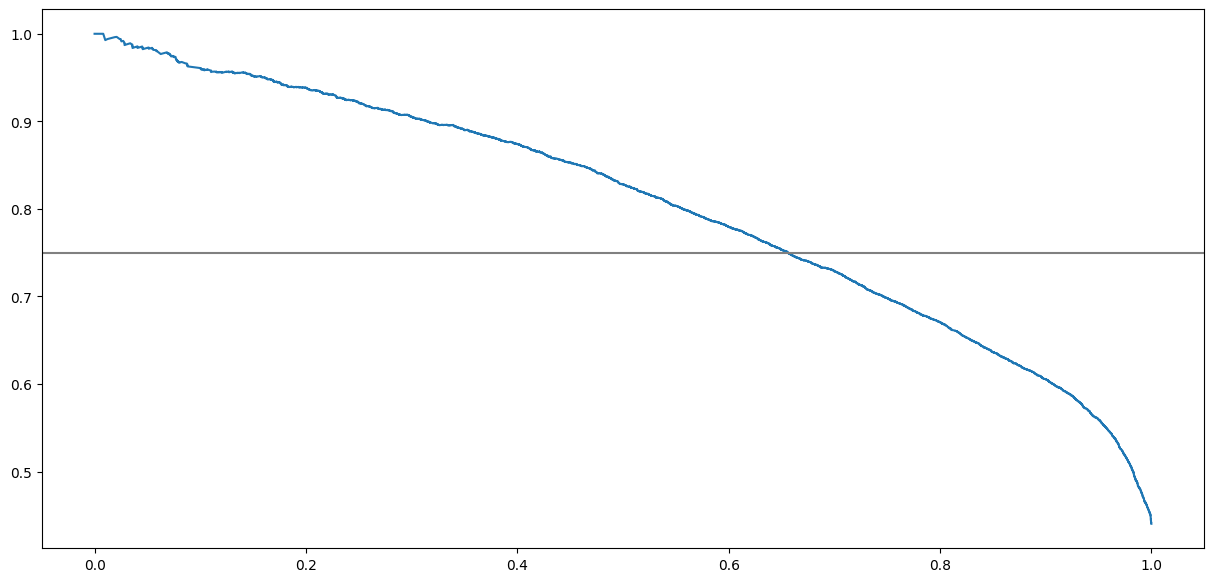

In [79]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [102]:
boosting_scores2 = X_test["scores"] = model2.predict_proba(X_test[feats])[:, 1]

In [103]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.41505724089206586

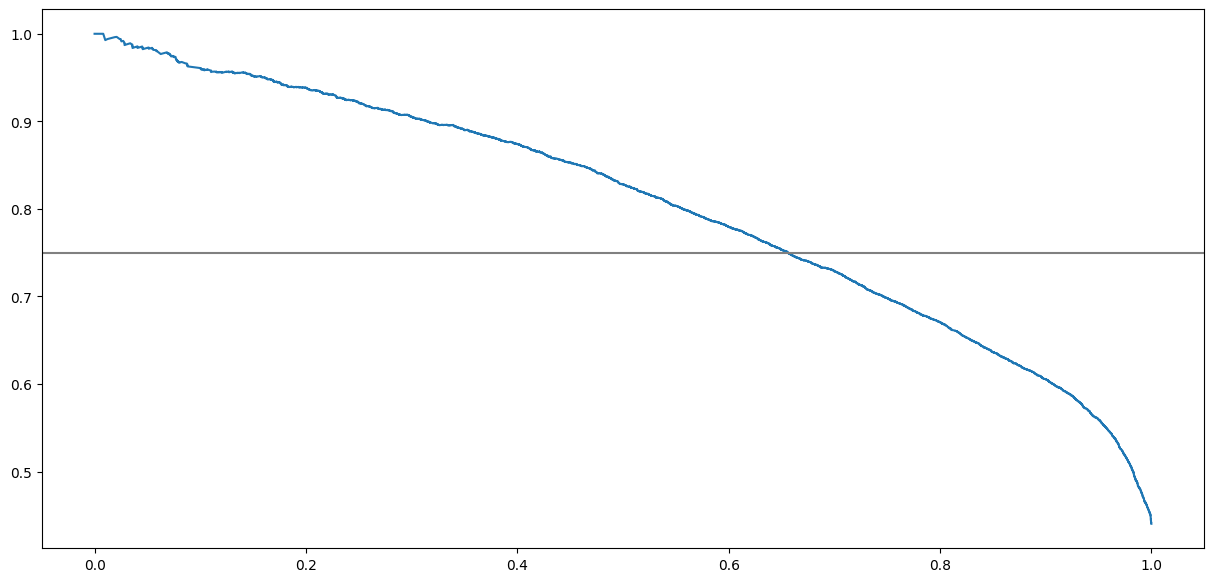

In [104]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [80]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=False)

In [ ]:
def eval_model(model, dataloader):
    pred_list = []
    model.eval()

    
    with torch.no_grad():
        for feats, _ in tqdm(dataloader):
            feats = feats.to(device)
            pred = model(feats)          
            pred_list.extend([prob1 for prob0, prob1 in pred.tolist()])

    return pred_list

In [92]:
dist_score_list = eval_model(net_model, test_dataloader)

100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


In [93]:
X_test["scores"] = dist_score_list

In [94]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.1652410212832041

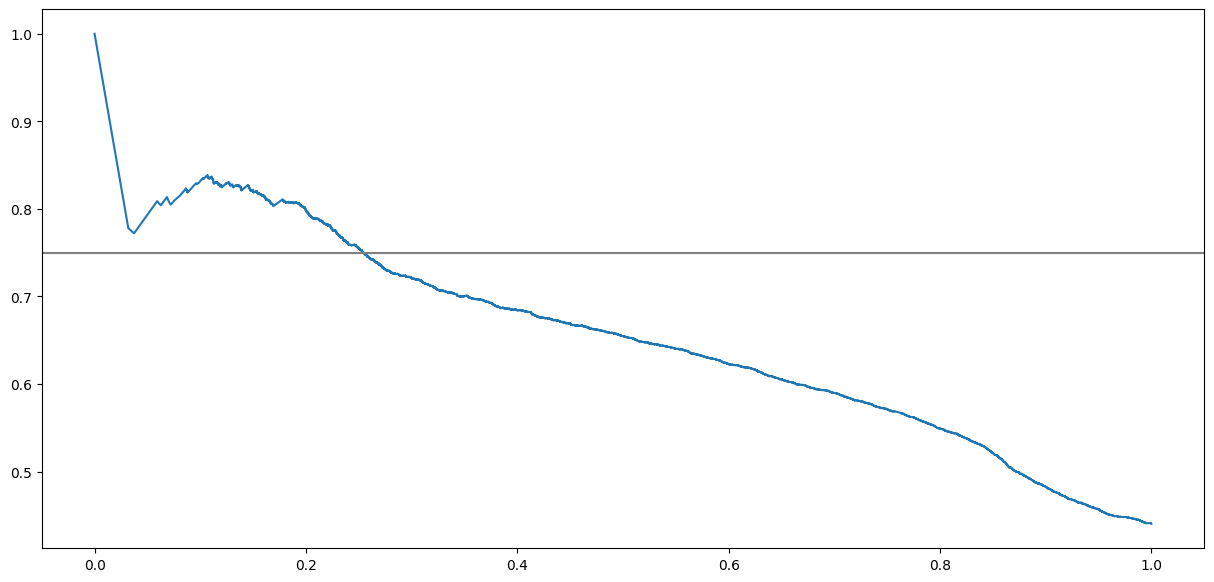

In [95]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [96]:
def test_siam_model(model, device, test_loader):
    pred_list = []
    model.eval()
    
    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2 = images_1.to(device), images_2.to(device)
            outputs = model(images_1, images_2).squeeze()
            pred_list.extend(outputs.tolist())
    return pred_list

In [97]:
siam_score_list = test_siam_model(siam_imgs_net, device, siam_test_loader)

In [98]:
X_test["scores"] = siam_score_list

In [99]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.27173954695949615

**Создадим метадатасет**

In [153]:
all_scores_list = [dist_score_list, boosting_scores, siam_score_list, list(X_test['main_cos_dist'])]

In [154]:
class MetaDataset(Dataset):
    def __init__(self, all_scores: List[Iterable[float]],
                 target_df: pd.DataFrame):
        """
        Args:
            dist_df: dataframe that contains only columns representing
            distances between properties of a product pair and 'target' column
            that equals 1 if the pair is same product, otherwise 0
        """
        self.features = list(zip(*all_scores))
        self.labels = list(target_df)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        inp = torch.tensor(self.features[idx], dtype = torch.float32)
        label = self.labels[idx]
        return inp, label

In [155]:
metadataset = MetaDataset(all_scores_list, y_test['target'])

In [156]:
metadataset[3]

(tensor([0.0003, 0.0832, 0.1055, 0.0000]), 0.0)

In [157]:
metadataset[3][0]

tensor([0.0003, 0.0832, 0.1055, 0.0000])

In [158]:
test_dataset[3][0]

tensor([0.0000e+00, 4.7200e+00, 5.4392e+00, 4.1154e-01, 5.1291e-03, 0.0000e+00,
        0.0000e+00])

**Попробуем сделать метамодель**

In [165]:
epox_num = 30
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

metamodel = Mega_model(len(all_scores_list)).to(device)

optimizer_meta = torch.optim.Adam(metamodel.parameters(), lr=3e-3)

In [166]:
meta_dataloader = DataLoader(metadataset, batch_size=100, shuffle=False, drop_last=False)
dataloaders_meta = {phase: meta_dataloader for phase in ['train', 'val']}

In [167]:
loss, acc, rec_1 = train_model(metamodel, criterion, optimizer_meta, epox_num, dataloaders_meta)

Epoch 1/30
----------


100%|██████████| 307/307 [00:00<00:00, 395.09it/s]


train loss: 0.6018, acc: 0.7079, rec_1: 0.7079


100%|██████████| 307/307 [00:00<00:00, 757.53it/s]


val loss: 0.5249, acc: 0.7449, rec_1: 0.7449
Epoch 2/30
----------


100%|██████████| 307/307 [00:00<00:00, 447.24it/s]


train loss: 0.5172, acc: 0.7835, rec_1: 0.7835


100%|██████████| 307/307 [00:00<00:00, 735.83it/s]


val loss: 0.5142, acc: 0.7850, rec_1: 0.7850
Epoch 3/30
----------


100%|██████████| 307/307 [00:00<00:00, 434.84it/s]


train loss: 0.5140, acc: 0.7861, rec_1: 0.7861


100%|██████████| 307/307 [00:00<00:00, 763.69it/s]


val loss: 0.5134, acc: 0.7860, rec_1: 0.7860
Epoch 4/30
----------


100%|██████████| 307/307 [00:00<00:00, 439.50it/s]


train loss: 0.5137, acc: 0.7862, rec_1: 0.7862


100%|██████████| 307/307 [00:00<00:00, 744.17it/s]


val loss: 0.5132, acc: 0.7857, rec_1: 0.7857
Epoch 5/30
----------


100%|██████████| 307/307 [00:00<00:00, 440.25it/s]


train loss: 0.5136, acc: 0.7860, rec_1: 0.7860


100%|██████████| 307/307 [00:00<00:00, 608.90it/s]


val loss: 0.5132, acc: 0.7858, rec_1: 0.7858
Epoch 6/30
----------


100%|██████████| 307/307 [00:00<00:00, 430.20it/s]


train loss: 0.5136, acc: 0.7857, rec_1: 0.7857


100%|██████████| 307/307 [00:00<00:00, 768.07it/s]


val loss: 0.5132, acc: 0.7857, rec_1: 0.7857
Epoch 7/30
----------


100%|██████████| 307/307 [00:00<00:00, 437.15it/s]


train loss: 0.5136, acc: 0.7858, rec_1: 0.7858


100%|██████████| 307/307 [00:00<00:00, 762.23it/s]


val loss: 0.5132, acc: 0.7858, rec_1: 0.7858
Epoch 8/30
----------


100%|██████████| 307/307 [00:00<00:00, 446.29it/s]


train loss: 0.5136, acc: 0.7857, rec_1: 0.7857


100%|██████████| 307/307 [00:00<00:00, 773.61it/s]


val loss: 0.5132, acc: 0.7857, rec_1: 0.7857
Epoch 9/30
----------


100%|██████████| 307/307 [00:00<00:00, 443.51it/s]


train loss: 0.5136, acc: 0.7857, rec_1: 0.7857


100%|██████████| 307/307 [00:00<00:00, 759.81it/s]


val loss: 0.5132, acc: 0.7857, rec_1: 0.7857
Epoch 10/30
----------


100%|██████████| 307/307 [00:00<00:00, 403.14it/s]


train loss: 0.5136, acc: 0.7857, rec_1: 0.7857


100%|██████████| 307/307 [00:00<00:00, 741.62it/s]


val loss: 0.5131, acc: 0.7857, rec_1: 0.7857
Epoch 11/30
----------


100%|██████████| 307/307 [00:00<00:00, 439.70it/s]


train loss: 0.5135, acc: 0.7857, rec_1: 0.7857


100%|██████████| 307/307 [00:00<00:00, 771.09it/s]


val loss: 0.5131, acc: 0.7857, rec_1: 0.7857
Epoch 12/30
----------


100%|██████████| 307/307 [00:00<00:00, 445.74it/s]


train loss: 0.5135, acc: 0.7856, rec_1: 0.7856


100%|██████████| 307/307 [00:00<00:00, 765.63it/s]


val loss: 0.5131, acc: 0.7857, rec_1: 0.7857
Epoch 13/30
----------


100%|██████████| 307/307 [00:00<00:00, 443.61it/s]


train loss: 0.5135, acc: 0.7856, rec_1: 0.7856


100%|██████████| 307/307 [00:00<00:00, 757.31it/s]


val loss: 0.5131, acc: 0.7857, rec_1: 0.7857
Epoch 14/30
----------


100%|██████████| 307/307 [00:00<00:00, 445.24it/s]


train loss: 0.5135, acc: 0.7857, rec_1: 0.7857


100%|██████████| 307/307 [00:00<00:00, 755.14it/s]


val loss: 0.5131, acc: 0.7857, rec_1: 0.7857
Epoch 15/30
----------


100%|██████████| 307/307 [00:00<00:00, 442.50it/s]


train loss: 0.5135, acc: 0.7856, rec_1: 0.7856


100%|██████████| 307/307 [00:00<00:00, 766.54it/s]


KeyboardInterrupt: 

**Посчитаем метрику на метамодели (что не очень честно, потому что она обучалсь на тех же данных, на которых мы метрику считаем**

In [168]:
metamodel_out_scores = eval_model(metamodel, meta_dataloader)

100%|██████████| 307/307 [00:00<00:00, 485.96it/s]


In [169]:
X_test["scores"] = metamodel_out_scores

In [170]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.4523775797282634

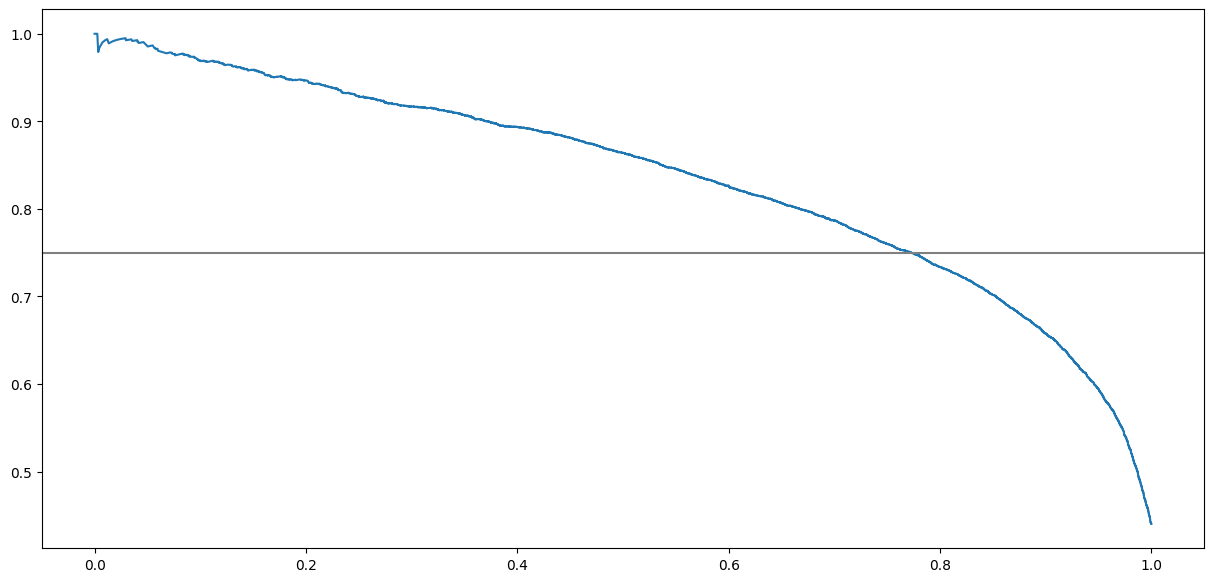

In [171]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

### Submission

In [105]:
test_pairs = pd.read_parquet("/kaggle/input/hackathon-files-for-participants-ozon/test_pairs_wo_target.parquet")
test_etl = pd.read_parquet("/kaggle/input/hackathon-files-for-participants-ozon/test_data.parquet")

Generate the same features as for train

In [106]:
test_features = (
    test_pairs
    .merge(
        test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [107]:
test_features.head(2)

,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,52076340,290590137,Батарейка AAA щелочная Perfeo LR03/10BL Super ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[0.15417035, 0.41160947, 0.2213532, -0.019731...","[[0.04763528, -0.20136409, 0.29605597, 0.26453...","[-0.28437558, 0.60909724, 0.5972025, -0.523296...","{""Напряжение, В"":[""1.5""],""Бренд"":[""Perfeo""],""Т...",Батарейка AAA щелочная Perfeo LR03/2BL mini Su...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[-0.025554053, 0.012488857, 0.43989864, -0.10...","[[0.06223978, -0.16145544, 0.26409012, 0.24271...","[-0.3380968, 0.6156224, 0.6428071, -0.57499236...","{""Форм-фактор батареи"":[""AAA""],""Химический тип..."
1,64525522,204128919,"Смартфон Ulefone Armor X5 3/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.239386, -0.8332473, -0.08384809, 0.071721...","[[-0.27325493, -0.6696304, 0.027148303, 0.0785...","[-0.45766184, 0.5528555, 0.26298037, -0.663931...","{""Операционная система"":[""Android""],""Защищенно...","Смартфон Ulefone Armor X3 2/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.071279265, -0.99063504, -0.3939417, 0.886...","[[-0.15358369, -0.8256463, -0.054863703, 0.453...","[-0.4489074, 0.6278857, 0.33072582, -0.6749875...","{""Встроенная память"":[""32 ГБ""],""Видеопроцессор..."


In [108]:
#! Переписать бы через apply

test_features['main_cos_dist'] = np.nan
test_features['main_evc_dist'] = np.nan
#from scipy.spatial.distance import cdist
from scipy import spatial
for ind in tqdm(test_features.index):
    #print(ind)
    cosine_val = cosine(test_features['main_pic_embeddings_resnet_v11'][ind][0], test_features['main_pic_embeddings_resnet_v12'][ind][0])
    evlid_val = euclidean(test_features['main_pic_embeddings_resnet_v11'][ind][0], test_features['main_pic_embeddings_resnet_v12'][ind][0])
    test_features.at[ind, 'main_cos_dist'] = cosine_val
    test_features.at[ind, 'main_evc_dist'] = evlid_val

100%|██████████| 18084/18084 [00:04<00:00, 4297.02it/s]


In [109]:
test_features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [110]:
test_features["cat3"] = test_features["categories1"].apply(lambda x: json.loads(x)["3"])

In [111]:
test_features.shape

(18084, 24)

In [112]:
test_cat3_counts = test_features["cat3"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [113]:
test_features["cat3_grouped"] = test_features["cat3"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")
# btw you can rename to `rest` the same categories that were assigned to this group in train

In [116]:
# добавим долю совпадающих численных значений

test_features[["numerical_intersection_percent"]] = (
    test_features[["name1", "name2"]].apply(
        lambda x: pd.Series(texts_to_intersection_percent(*x)), axis=1
    )
)

In [117]:
submission_example = test_features.copy()

In [119]:
catboost_submission_scores = model.predict_proba(test_features[feats])[:, 1]

In [149]:
# y не будет использоваться. Хотел сделать его списком None, но даталоадер ругается если элементы разных типов
# поэтому сделал списком -1 
submission_dist_dataset = DistDataset(test_features[dist_feats], [-1]*len(test_features))
submission_dist_dataloader = DataLoader(submission_dist_dataset, batch_size=len(submission_dist_dataset), shuffle=False, drop_last=False)

In [150]:
dist_model_submission_scores = eval_model(net_model, submission_dist_dataloader)

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


In [151]:
len(dist_model_submission_scores)

18084

In [172]:
submission_siam_dataset = SiamiseMainImgDataset(
    test_features['main_pic_embeddings_resnet_v11'],
    test_features['main_pic_embeddings_resnet_v12'],
    [-1]*len(test_features))

submission_siam_loader = DataLoader(submission_siam_dataset, batch_size=100, shuffle=False, drop_last=False)

In [174]:
sub_siam_score_list = test_siam_model(siam_imgs_net, device, submission_siam_loader)

In [177]:
# Важно соблюсти тот же порядок, что и при обучении! (понимаю, что я капитан очевидность)
submission_scores_list = [dist_model_submission_scores, catboost_submission_scores, sub_siam_score_list, list(test_features['main_cos_dist'])] 

In [178]:
submission_metadataset = MetaDataset(submission_scores_list, [-1]*len(submission_scores_list[0]))
sub_meta_dataloader = DataLoader(submission_metadataset, batch_size=len(submission_scores_list), shuffle=False, drop_last=False)

In [179]:
final_meta_scores = eval_model(metamodel, sub_meta_dataloader)

100%|██████████| 4521/4521 [00:01<00:00, 2485.95it/s]


In [180]:
submission_example["target"] = final_meta_scores

In [181]:
submission_example.head(2)

,variantid1,variantid2,target
0,52076340,290590137,0.009577
1,64525522,204128919,0.166921


In [182]:
submission_example = submission_example[["variantid1", "variantid2", "target"]]

In [187]:
submission_example.head(2)

,variantid1,variantid2,target
0,52076340,290590137,0.009577
1,64525522,204128919,0.166921


In [185]:
submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_example_meta_new.csv", index=False)

Upload your submission to leaderboard :)

In [193]:
# submission_example["target"] = catboost_submission_scores

In [194]:
# submission_example.drop_duplicates().merge(
#     test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
#     on=["variantid1", "variantid2"]
# ).to_csv("catboost_1.csv", index=False)

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.

In [198]:
torch.save({
            'siamese_model_state_dict': siam_imgs_net.state_dict(),
            'siamese_optimizer_state_dict': optimizer.state_dict(),
            'distance_model_state_dict': net_model.state_dict(),
            'distance_model_optimizer_state_dict': 'утрачено :(',
            'metamodel_state_dict': metamodel.state_dict(),
            'metaoptimizer_state_dict': optimizer_meta.state_dict(),
            }, "31_05_23__1_10.pt")

In [197]:
modelA =  Mega_model(len(dist_feats))
modelB = SiameseNetwork(in_features = resnet_emb_dim)
modelC = Mega_model(len(all_scores_list))
optimizerA = torch.optim.Adam(modelA.parameters(), lr=3e-3)
optimizerB = torch.optim.Adadelta(modelB.parameters(), lr=lr)
optimizerC = torch.optim.Adam(modelA.parameters(), lr=3e-3)

checkpoint = torch.load("31_05_23__1_10.pt")
modelA.load_state_dict(checkpoint['distance_model_state_dict'])
modelB.load_state_dict(checkpoint['siamese_model_state_dict'])
modelC.load_state_dict(checkpoint['metamodel_state_dict'])
optimizerB.load_state_dict(checkpoint['siamese_optimizer_state_dict'])
optimizerC.load_state_dict(checkpoint['metaoptimizer_state_dict'])


modelA.eval()
modelB.eval()
# - or -
modelA.train()
modelB.train()

SiameseNetwork(
  (feature_extractor): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)